In [1]:
# Christian Ibanez - Exploration Data.

Here I will be looking at other approaches and replicated them to get more familar with the competition. Then I will work creatively to come up with my own solution and present it within my team. 

In [4]:
# # Test lines for the utility script.
# from homecredit_prep_utility import *
# homecredit_prep_utility

# df_info = {
#     "name":"tax_registry_c_1",
#     "depth":2,
#     "feature_types":["A","M"]
# }
# train_df, submit_df = load_df(**df_info)
# train_df.head()

In [8]:
import sklearn
print(sklearn.__version__)

import os, glob
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Literal
import polars as pl
import polars.selectors as cs
from sklearn.model_selection import train_test_split, cross_validate, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import shap

1.2.2


In [9]:
if os.path.exists('/kaggle'):
    PATH_DATASET = Path("/kaggle/input/home-credit-credit-risk-model-stability")
else:
    PATH_DATASET = Path("home-credit-credit-risk-model-stability")
PATH_PARQUETS = PATH_DATASET / "parquet_files"
PATH_TRAIN = PATH_PARQUETS / "train"
PATH_TEST = PATH_PARQUETS / "test"

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Read and merge data
We are using  the Class DatasetConstructor to setup our initial dataframe. The DatasetContructor reads the parquet data files (base,static and static_cb) using polars library and then:

1) Cast integer, float variables into other datatypes to reduce the amount of memory allocated.
2) Cast string features to the appropiate datetime and categorical.
3) Merge static and static_cb datasets by case_id with base dataframe.
4) Convert the polars dataframe back for  pandas dataframe.

In [3]:
class DatasetConstructor:
    def __init__(self, mode: Literal['train', 'test']):
        self.mode = mode
        self.path = PATH_PARQUETS / mode

    @staticmethod
    def reduce_memory_usage_pl(df):
        """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
            Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
        print(f"Memory usage of dataframe is {round(df.estimated_size('mb'), 2)} MB")
        Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
        Numeric_Float_types = [pl.Float32,pl.Float64]    
        for col in df.columns:
            try:
                col_type = df[col].dtype
                if col_type == pl.Categorical:
                    continue
                c_min = df[col].min()
                c_max = df[col].max()
                if col_type in Numeric_Int_types:
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df = df.with_columns(df[col].cast(pl.Int8))
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df = df.with_columns(df[col].cast(pl.Int16))
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df = df.with_columns(df[col].cast(pl.Int32))
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df = df.with_columns(df[col].cast(pl.Int64))
                elif col_type in Numeric_Float_types:
                    if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df = df.with_columns(df[col].cast(pl.Float32))
                    else:
                        pass
                # elif col_type == pl.Utf8:
                #     df = df.with_columns(df[col].cast(pl.Categorical))
                else:
                    pass
            except:
                pass
        print(f"Memory usage of dataframe became {round(df.estimated_size('mb'), 2)} MB")
        return df

    @staticmethod
    def detect_datetime_cols(df):
        return df.select_dtypes(object).apply(lambda x: pd.to_datetime(x, errors='ignore'), axis=0).select_dtypes(np.datetime64).columns.tolist()
                        
    def _to_pandas(self, df):
        df = df.to_pandas().set_index('case_id')
        df = df.replace([np.inf, -np.inf], np.nan)
        return df

    def merge_static(self, df):
        df_static = (
            pl.concat([pl.scan_parquet(p, low_memory=True) for p in glob.glob(str(self.path / f"{self.mode}_static_0_*"))],how="vertical_relaxed",)
            .with_columns(
                [
                    (pl.col(col).cast(pl.String).str.to_date(strict=False)) 
                    for col in [
                        'datefirstoffer_1144D', 
                        'datelastinstal40dpd_247D',
                        'datelastunpaid_3546854D', 
                        'dtlastpmtallstes_4499206D',
                        'firstclxcampaign_1125D', 
                        'firstdatedue_489D', 
                        'lastactivateddate_801D',
                       'lastapplicationdate_877D', 
                        'lastapprdate_640D', 
                        'lastdelinqdate_224D',
                       'lastrejectdate_50D', 
                        'lastrepayingdate_696D',
                       'maxdpdinstldate_3546855D', 
                        'payvacationpostpone_4187118D',
                       'validfrom_1069D'
                    ]
                ] + [
                    (pl.col(col).cast(pl.String).cast(pl.Categorical))
                    for col in [
                        'bankacctype_710L', 'cardtype_51L', 'credtype_322L',
                       'disbursementtype_67L', 'equalitydataagreement_891L',
                       'equalityempfrom_62L', 'inittransactioncode_186L',
                       'isbidproductrequest_292L', 'isdebitcard_729L',
                       'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M',
                       'lastcancelreason_561M', 'lastrejectcommoditycat_161M',
                       'lastrejectcommodtypec_5251769M', 'lastrejectreason_759M',
                       'lastrejectreasonclient_4145040M', 'lastst_736L', 'opencred_647L',
                       'paytype1st_925L', 'paytype_783L', 'previouscontdistrict_112M',
                       'twobodfilling_608L', 'typesuite_864L'
                    ]
                ]
            )
        )
        return df.join(df_static, how="left", on="case_id")
        
    def merge_static_cb(self, df):
        df_static_cb = (
            pl.scan_parquet(self.path / f"{self.mode}_static_cb_0.parquet", low_memory=True)
            .with_columns(
                [
                    (pl.col(col).cast(pl.String).str.to_date(strict=False)) 
                    for col in [
                        'assignmentdate_238D', 
                        'assignmentdate_4527235D',
                        'assignmentdate_4955616D', 
                        'birthdate_574D', 
                        'dateofbirth_337D',
                        'dateofbirth_342D', 
                        'responsedate_1012D', 
                        'responsedate_4527233D',
                        'responsedate_4917613D'
                    ] 
                ] + [
                    (pl.col(col).cast(pl.String).cast(pl.Categorical))
                    for col in [
                        'description_5085714M', 'education_1103M', 'education_88M',
                       'maritalst_385M', 'maritalst_893M', 'requesttype_4525192L',
                       'riskassesment_302T'
                    ]
                ]
            )
        )
        return df.join(df_static_cb, how="left", on="case_id")
    
    
    def load(self):
        df = pl.scan_parquet(self.path / f"{self.mode}_base.parquet", low_memory=True).with_columns(
            pl.col("date_decision").str.to_date()
        )
        # Depth=0
        df = self.merge_static(df)
        df = self.merge_static_cb(df)
        
        df =(
            df
            .with_columns(
                pl.col(pl.Float64).cast(pl.Float32),
                pl.col(pl.Int64).cast(pl.Int32),
            )
        )
        df = df.select(~cs.date())
        
         # Drop categorical large-dimension columns
        df = df.drop([
            'lastapprcommoditytypec_5251766M',
             'previouscontdistrict_112M',
             'district_544M',
             'profession_152M',
             'name_4527232M',
             'name_4917606M',
             'employername_160M',
             'classificationofcontr_400M',
             'financialinstitution_382M',
             'contaddr_district_15M',
             'contaddr_zipcode_807M',
             'empladdr_district_926M',
             'empladdr_zipcode_114M',
             'registaddr_district_1083M',
             'registaddr_zipcode_184M',
             'addres_district_368M',
             'addres_zip_823M'])       
        
        # Materialize the LazyFrame to DataFrame to work with dtype and n_unique() as these are not directly supported in LazyFrame.          
        df = df.collect()
        df = self.reduce_memory_usage_pl(df)
        df = self._to_pandas(df)
        
        return df

We modify the original summary function (Ref:) so that it takes a dataframe and returns a dataframe that summarizes it. It will return the following aggregations. 
* #total - The total of rows.
* #missing - The number of missing values per feature.
* %missing - The proportion of missing values. This will be one of values we are going to look to determine if a feature needs to be drop from the dataset.
* #unique - Number of unique values in the feature.
* #duplicates - To identy the dispersion of the data around the unique values. We will also look into this to determine  if feature needs to be dropped.
* min - The min value for the feature (if applicable).
* max - The max value for the feature (if applicable).
*Class_0_count - Count of occurrences  in the feature for class 0 (majority class).
*Class_1_count - Count of occurrences in the feature for class 1 (miniority class).
*Class_0_mean - Mean of occurrences  in the feature for class 0 (majority class).
*Class_1_mean - Mean of occurrences in the feature for class 1 (miniority class).


In [4]:
def summary(df):
    ''' This function returns a summary of the quality of the data'''
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    # Total of row entries.
    summ['#total'] = df.shape[0]
    # Number of missing values.
    summ['#missing'] = df.isnull().sum().values 
    # Proportion of missing values with respect the number of entries.
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    # Number of unique values.
    summ['#unique'] = df.nunique().values
    # Number of distinct values . To understand  the spread of the values.
    summ['#duplicates'] = summ['#total'] - summ['#unique']
    #  Transposing the data frame to get max and min values.
    desc = pd.DataFrame(df.describe(include='all').transpose())
    # Calculating the min values.
    summ['min'] = desc['min'].values
    # Calculating the max values.
    summ['max'] = desc['max'].values    
    # Calculating the average values
    summ['mean'] = desc['mean'].values    
    
    
    summ['Class_0_count'] =  0
    summ['Class_1_count'] = 0
    
    
#     This portion of the code is to  generate counts grouped per target class.
    
    grpd_df = df.groupby('target').describe(include='all') 
    
    for column in df.columns:
        if column != 'target':  # Exclude the 'target' column itself
            summ.loc[column, 'Class_0_count'] = grpd_df[column]['count'][0]
            summ.loc[column, 'Class_0_mean'] = grpd_df[column]['mean'][0]
            
            summ.loc[column, 'Class_1_count'] = grpd_df[column]['count'][1]
            summ.loc[column, 'Class_1_mean'] = grpd_df[column]['mean'][1]
            
            
    summ['imbalance_Prop'] =  summ['Class_1_count'] / summ['Class_0_count']  
            
    
    return summ

## Data Loading

In [10]:
train_constructor = DatasetConstructor('train')
df_train = train_constructor.load()
df_train.info()
# df_train

Memory usage of dataframe is 1168.76 MB
Memory usage of dataframe became 1160.02 MB
<class 'pandas.core.frame.DataFrame'>
Index: 1526659 entries, 0 to 2703454
Columns: 196 entries, MONTH to thirdquarter_1082L
dtypes: bool(1), category(28), float32(164), int32(1), int8(2)
memory usage: 1013.3 MB


,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,cardtype_51L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_136L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,eir_270L,equalitydataagreement_891L,equalityempfrom_62L,homephncnt_628L,inittransactionamount_650A,inittransactioncode_186L,interestrate_311L,interestrategrace_34L,isbidproduct_1095L,isbidproductrequest_292L,isdebitcard_729L,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastcancelreason_561M,lastdependentsnum_448L,lastotherinc_902A,lastotherlnsexpense_631A,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxannuity_4075009A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,contractssum_5085716L,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,for3years_128L,for3years_504L,for3years_584L,formonth_118L,formonth_206L,formonth_535L,forquarter_1017L,forquarter_462L,forquarter_634L,fortoday_1092L,forweek_1077L,forweek_528L,forweek_601L,foryear_618L,foryear_818L,foryear_850L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtcount_4527229L,pmtcount_4955617L,pmtcount_693L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,riskassesment_302T,risk

## Data Cleaning

In [6]:
# The code below is to reduce variables based on on the following criteria.
# a) Features that only have one distinct value (most of the times  0.0).
# b) Removing categorical variables as this would need to be converted to dummy features.
# c) Removing features that are highly correlated



# List of features that need to be removed as there is only one single value.
# This list is defined after looking/exploring the summary dataframe.
columns_single_val = ['bankacctype_710L','commnoinclast6m_3546845L','deferredmnthsnum_166L',
               'formonth_118L','forquarter_462L','interestrategrace_34L','isdebitcard_729L',
               'mastercontrelectronic_519L','mastercontrexist_109L','paytype_783L','paytype1st_925L','typesuite_864L']

# Code to determine what are the categorical variables.

# Creating summary dataframe.
x = summary(df_train)
# Creating a dataframe  for the categorical features.
cat_df = x[x['data type'] == 'category']
#Creating a list for the categorical features.
cat_lst = cat_df.index.to_list()





# Extending list to 

# Extending categorical_list and sinle_val list into one single list.
feats_to_delete_lst = columns_single_val + cat_lst

# Converting to a set to remove duplicates.
feats_to_delete_lst = list(set(feats_to_delete_lst))
    
# feats_to_delete_lst

In [7]:
df_train.corr()

ValueError: could not convert string to float: 'CA'

In [32]:
# Generating a reduced dataframe  without categorical variables.
red_df = df_train.drop(feats_to_delete_lst, axis=1)

red_df = red_df.reset_index()

# Features and Target variable
X = red_df.drop(['case_id','target'], axis=1)
y = red_df['target']

# Standardized Scalar for numeric variables
sc=StandardScaler()
X=sc.fit_transform(X)

# Split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=888)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 100,
    "verbose": -1,
    "random_state": 888
}

lgb_model = lgb.LGBMClassifier(**params)
lgb_model.fit(X_train, y_train)

y_pred = lgb_model.predict_proba(X_test)[:, 1]


In [33]:
# create a new dataframe for X to get the column names in SHAP
df_X = pd.DataFrame(X, columns=red_df.drop(['case_id','target'], axis=1).columns)

# Extract the SHAP values
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


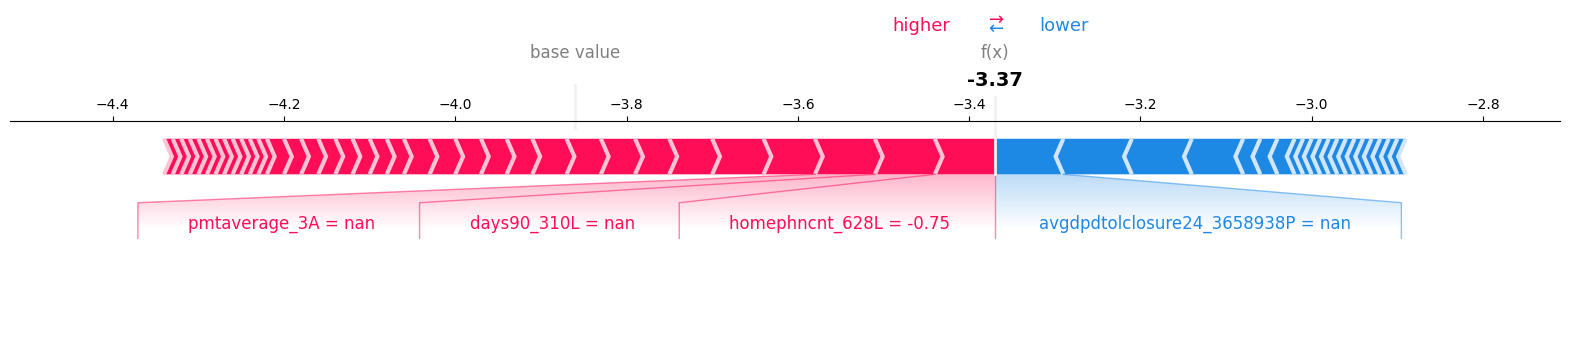

In [36]:
shap.initjs()
cust = 5 # Select the customer to observe
shap.force_plot(
    np.round(explainer.expected_value[1], decimals=2), 
    np.round(shap_values[1][cust, :], decimals=2), 
    np.round(df_X.iloc[cust,:], decimals=2), 
    matplotlib=plt
    
)


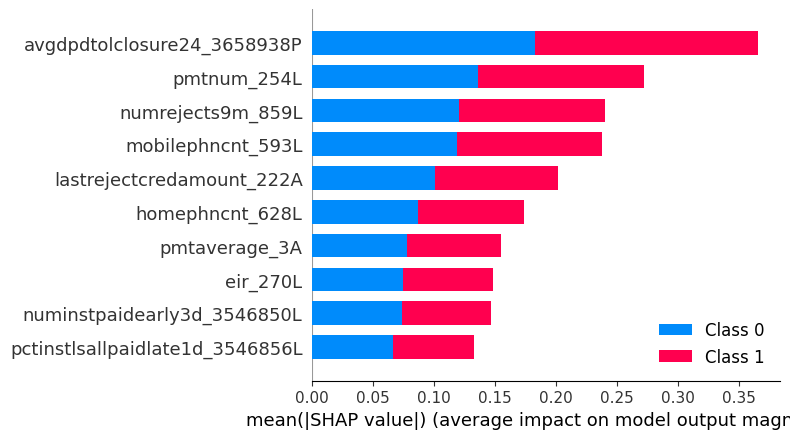

In [37]:
shap.initjs()
shap.summary_plot(shap_values, X, df_X.columns, plot_size=0.3, max_display=10)

In [42]:
# Initial Results
avgdpdtolclosure24_3658938P
pmtnum
numrejects
mobilephncnt
lastrejectcredamount
homephncnt
pmtaverage
eir
numintspaidearly
pcintallpaidlate


TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [43]:
x.style.background_gradient(cmap='Blues')

,data type,#total,#missing,%missing,#unique,#duplicates,min,max,mean,Class_0_count,Class_1_count,Class_0_mean,Class_1_mean,imbalance_Prop
MONTH,int32,1526659,0,0.000000,22,1526637,201901.000000,202010.000000,201936.287982,1478665,47994,201936.248693,201937.498458,0.032458
WEEK_NUM,int8,1526659,0,0.000000,92,1526567,0.000000,91.000000,40.769036,1478665,47994,40.756306,41.161249,0.032458
target,int8,1526659,0,0.000000,2,1526657,0.000000,1.000000,0.031437,0,0,nan,nan,nan
actualdpdtolerance_344P,float32,1526659,418178,27.391710,170,1526489,0.000000,4206.000000,0.079234,1072272,36209,0.073318,0.254412,0.033768
amtinstpaidbefduel24m_4187115A,float32,1526659,561124,36.755032,610152,916507,0.000000,1408010.250000,55958.320312,933465,32070,56556.289062,38553.546875,0.034356
annuity_780A,float32,1526659,0,0.000000,75325,1451334,80.800003,106007.000000,4039.206543,1478665,47994,4031.712891,4270.144531,0.032458
annuitynextmonth_57A,float32,1526659,4,0.000262,66202,1460457,0.000000,87500.000000,1435.774780,1478661,47994,1432.549927,1535.143921,0.032458
applicationcnt_361L,float32,1526659,0,0.000000,5,1526654,0.000000,5.000000,0.000022,1478665,47994,0.000020,0.000083,0.032458
applications30d_658L,float32,1526659,0,0.000000,25,1526634,0.000000,28.000000,0.138152,1478665,47994,0.134538,0.249510,0.032458
applicationscnt_1086L,float32,1526659,0,0.000000,125,1526534,0.000000,728.000000,0.424510,1478665,47994,0.425501,0.393966,0.032458


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


TypeError: Invalid object type at position 0

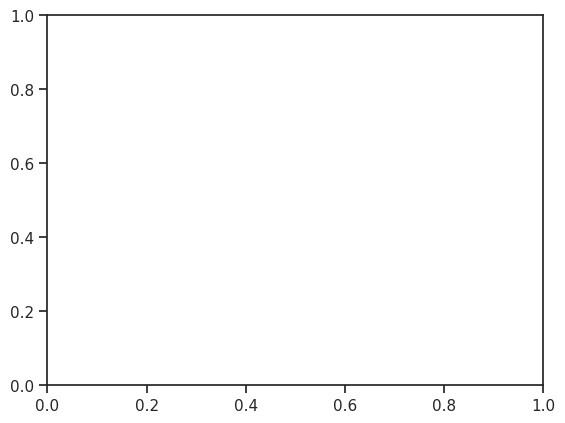

In [58]:
# df_train['BIN_avgdpdtolclosure24_3658938P'] = pd.cut(df_train['avgdpdtolclosure24_3658938P'], 2, labels=['low', 'medium'])
interval = pd.interval_range(start=1, end=60, periods=9)
df_train['BIN_pmtnum_254L'] = pd.cut(df_train['pmtnum_254L'],
                                     bins=interval,
                                     labels=['0-6months', '7-12months', '13-18months', '19-24months', '25-30months', '30-100months'])
sns.histplot(x='BIN_pmtnum_254L', data=df_train, hue='target')

In [55]:
df_train['BIN_pmtnum_254L']

case_id
0          (18.700000000000003, 24.6]
1          (12.8, 18.700000000000003]
2          (30.5, 36.400000000000006]
3                         (6.9, 12.8]
4          (18.700000000000003, 24.6]
                      ...            
2703450                   (6.9, 12.8]
2703451    (18.700000000000003, 24.6]
2703452                   (6.9, 12.8]
2703453                    (1.0, 6.9]
2703454                   (6.9, 12.8]
Name: BIN_pmtnum_254L, Length: 1526659, dtype: category
Categories (10, interval[float64, right]): [(1.0, 6.9] < (6.9, 12.8] < (12.8, 18.700000000000003] < (18.700000000000003, 24.6] ... (36.400000000000006, 42.300000000000004] < (42.300000000000004, 48.2] < (48.2, 54.1] < (54.1, 60.0]]

In [28]:
ds = df_train[df_train['pmtnum_254L'].isin([np.inf, -np.inf]) == True]
print(ds)

Empty DataFrame
Columns: [MONTH, WEEK_NUM, target, actualdpdtolerance_344P, amtinstpaidbefduel24m_4187115A, annuity_780A, annuitynextmonth_57A, applicationcnt_361L, applications30d_658L, applicationscnt_1086L, applicationscnt_464L, applicationscnt_629L, applicationscnt_867L, avgdbddpdlast24m_3658932P, avgdbddpdlast3m_4187120P, avgdbdtollast24m_4525197P, avgdpdtolclosure24_3658938P, avginstallast24m_3658937A, avglnamtstart24m_4525187A, avgmaxdpdlast9m_3716943P, avgoutstandbalancel6m_4187114A, avgpmtlast12m_4525200A, bankacctype_710L, cardtype_51L, clientscnt12m_3712952L, clientscnt3m_3712950L, clientscnt6m_3712949L, clientscnt_100L, clientscnt_1022L, clientscnt_1071L, clientscnt_1130L, clientscnt_136L, clientscnt_157L, clientscnt_257L, clientscnt_304L, clientscnt_360L, clientscnt_493L, clientscnt_533L, clientscnt_887L, clientscnt_946L, cntincpaycont9m_3716944L, cntpmts24_3658933L, commnoinclast6m_3546845L, credamount_770A, credtype_322L, currdebt_22A, currdebtcredtyperange_828A, daysove

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


TypeError: Invalid object type at position 0

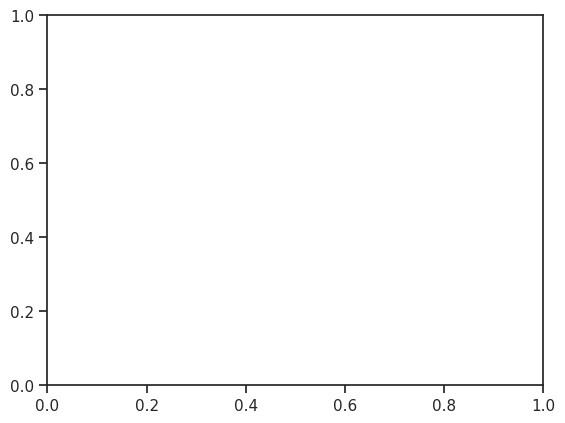

In [56]:
sns.histplot(x='BIN_pmtnum_254L', data=df_train, hue='target')

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a lengt

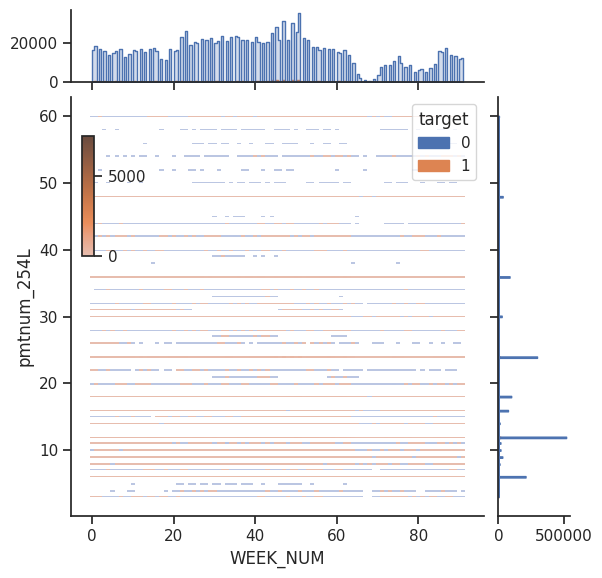

In [42]:

sns.set_theme(style="ticks")

# Load the planets dataset and initialize the figure
g = sns.JointGrid(data=df_train, x="WEEK_NUM", y="pmtnum_254L",hue='target', marginal_ticks=True)

# Set a log scaling on the y axis
# g.ax_joint.set(yscale="log")

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

In [45]:
sns.jointplot(x='WEEK_NUM', y='pmtnum_254L', kind="hex", color="#4CB391", data=df_train)

ValueError: Use of `hue` with `kind='hex'` is not currently supported.

In [ ]:

x.style.background_gradient(cmap='Blues')


In [ ]:
x.style.background_gradient(cmap='Blues')

In [ ]:

cat_vals

In [ ]:

# Dropping columns that are categories for now, as we n

In [ ]:
cat_col_dummy = ['credtype_322L', 'disbursementtype_67L','equalitydataagreement_891L']
df_train['equalitydataagreement_891L'].unique()



In [ ]:
sns.relplot(x='cardtype_51L', y = 'WEEK_NUM',hue = 'target', data=df_train)

In [ ]:
sns.histplot(x='pmtssum_45A', hue = 'target', data=df_train,bins=30)

We wanted to explore the quality of the data, and be able to visualize the proportion of missing values for each of the variables in the dataframe, as well as the min/max values

In [ ]:
# pip install pycaret

In [ ]:
import pandas as pd
from pycaret.classification import *


df_sample = df_train.sample(n=20000, random_state=42)  # Set random_state for reproducibility

# PyCaret Setup
clf_exp = setup(data=df_sample, target='target', session_id=123)  # Replace 123 with a unique ID

# Model Comparison and Selection
best_model = compare_models(verbose=True)
print("Top Models based on AUC:")
print(best_model[['Model', 'AUC']].sort_values(by='AUC', ascending=False).head(3))  # View top 3 models

# # Select the model with the highest AUC (replace 'LightGBMClassifier' with the actual best model name)
# chosen_model = clf_exp.models['LightGBMClassifier']  # Replace with the best model name from compare_models

# # Optional Hyperparameter Tuning (uncomment if desired)
# # tuned_model = tune_model(chosen_model)

# # Prediction on unseen data (assuming you have a separate test set named 'df_test')
# predictions = predict_model(chosen_model, data=df_test)

# # Function to calculate Gini stability (same as your previous implementation)
# def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
#     gini_in_time = base.loc[:, ["WEEK_NUM", "target", "predicted_proba"]]\
#         .sort_values("WEEK_NUM")\
#         .groupby("WEEK_NUM")[["target", "predicted_proba"]]\
#         .apply(lambda x: 2*roc_auc_score(x["target"], x["predicted_proba"])-1).tolist()
    
#     x = np.arange(len(gini_in_time))
#     y = gini_in_time
#     a, b = np.polyfit(x, y, 1)
#     y_hat = a*x + b
#     residuals = y - y_hat
#     res_std = np.std(residuals)
#     avg_gini = np.mean(gini_in_time)
#     return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

# # Evaluate Stability on unseen test data split by week
# week_groups = df_test.groupby('WEEK_NUM')
# stability_results = []
# for name, group in week_groups:
#   stability_results.append(gini_stability(group.copy()))

# print(f"Average Gini Stability of {chosen_model.label}: {np.mean(stability_results)}")

# # Explore further analysis or visualization of stability results

In [ ]:

import sklearn
print(sklearn.__version__)

## Train simple LGBM 

In [ ]:
X, y = df_train.drop(columns='target'), df_train['target']
X.shape

In [ ]:
X = X.drop(columns=['WEEK_NUM'] ) 


In [ ]:
# %%time
# params = {
#     "boosting_type": "gbdt",
#     "objective": "binary",
#     "metric": "auc",
#     "max_depth": 8,
#     "num_leaves": 32,
#     "min_data_in_leaf": 10,
#     "learning_rate": 0.05,
#     "feature_fraction": 0.8,
#     "bagging_fraction": 0.8,
#     "bagging_freq": 5,
#     "n_estimators": 100,
#     'min_data_in_bin':1,
#     'max_bin': 64,
#     "verbose": -1,
#     "random_state": 42, 
#     'n_jobs': -1
# }
# cv = StratifiedGroupKFold(n_splits=10, shuffle=False)
# cv_results = cross_validate(
#     lgb.LGBMClassifier(**params), 
#     X, y, 
#     groups=df_train['WEEK_NUM'], 
#     scoring='roc_auc', 
#     cv=cv,
#     verbose=3, 
#     return_indices =True,
#     return_estimator=True 
# )
# print(f"AUC: {cv_results['test_score'].mean():.3f}", f"+-{cv_results['test_score'].std():.3f}")

In [ ]:
# stability_results = []
# for fold, (idx, model) in enumerate(zip(cv_results['indices']['test'], cv_results['estimator'])):
#     df_res = pd.DataFrame()
    
#     df_res['WEEK_NUM'] = df_train['WEEK_NUM'].iloc[idx].values
#     df_res['target'] = df_train['target'].iloc[idx].values
#     df_res['score'] = model.predict_proba(X.iloc[idx])[:, 1]
#     df_res['fold'] = fold
#     stability_results.append(df_res)
    
# df_stability_results = pd.concat(stability_results)
# df_stability_results[df_stability_results['target'] == 0]['score'].plot(kind='hist', alpha=0.5, bins=100, label='target=0')
# df_stability_results[df_stability_results['target'] == 1]['score'].plot(kind='hist', secondary_y=True, alpha=0.5, bins=100, label='target=1')
# plt.legend();

In [ ]:
# sns.boxenplot(df_stability_results, y='score', x='target');


In [ ]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

try:
    df_stability_results.groupby('fold').apply(gini_stability, include_groups=False)
except:
    pass

In [ ]:
# gini_stability(df_stability_results)


# Plan moving forward 
1. look into pycaret and how that mighht work for this problem 
2. look into other methods and examples that would improve our prediction methods 
3. find examples on youtube or github? 
4. maybe get familar with kaggle notebooks and stuff to 

In [ ]:
# models = cv_results['estimator']


In [ ]:
# del df_train, X, y
# gc.collect()

## Loading Test Data

In [ ]:
# test_constructor = DatasetConstructor('test')
# df_test=test_constructor.load()

# Predict and submit


In [ ]:
# test = df_test[models[0].feature_name_]
# preds_proba = [model.predict_proba(test)[:, 1] for model in models]
# df_test["score"] = np.average(preds_proba, axis=0)
# df_test[["score"]].to_csv("submission_0.csv")

## Ensemble??

In [ ]:
# sub_0 = pd.read_csv("submission_0.csv", dtype={"case_id": int}).set_index("case_id")
# sub_1 = pd.read_csv("submission_1.csv", dtype={"case_id": int}).set_index("case_id")
# sub_2 = pd.read_csv("submission_2.csv", dtype={"case_id": int}).set_index("case_id")
# sub_3 = pd.read_csv("submission_3.csv", dtype={"case_id": int}).set_index("case_id")
# sub_4 = pd.read_csv("submission_4.csv", dtype={"case_id": int}).set_index("case_id")

# sub = 0.42*sub_4 + 0.48*sub_3 + 0.1*(0.95*sub_2 + 0.05*(0.8*sub_0 + 0.2*sub_1))

In [ ]:
# test = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/csv_files/test/test_base.csv")
# # sub = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv", dtype={"case_id": int}).set_index("case_id")
# SHIFT = 0.025
# week_num = list(test["WEEK_NUM"])
# sub["WEEK_NUM"] = week_num
# condition = sub["WEEK_NUM"] < (sub["WEEK_NUM"].max() - sub["WEEK_NUM"].min())/2 + sub["WEEK_NUM"].min()
# sub.loc[condition, 'score'] = (sub.loc[condition, 'score'] - SHIFT).clip(0)
# del sub["WEEK_NUM"]
# sub.to_csv("submission.csv")

In [ ]:
df = pd.DataFrame({
    'data': [1, 7, 5, 4, 6, 3, 9, 2, 8, 10],
    'data2': [2, np.nan, 1, 4, 2, 1, 5, 2, 1, 3],  # Assumed correction for missing value and alignment with given task
    'target': [0, 0, 1, 1, 0, 0, 0, 1, 1, 0]  # Assumed correction for '01' to 1
})


# Group by the 'target' column and use describe()
grouped_df = df.groupby('target').describe()

# Prepare the data for the new DataFrame
data = {
    'index': [],
    'count_class_0': [],
    'count_class_1': [],
}

# Populate the new data structure
for column in df.columns:
    if column != 'target':  # Exclude the 'target' column itself
        data['index'].append(column)
        data['count_class_0'].append(grouped_df[column]['count'][0])
        data['count_class_1'].append(grouped_df[column]['count'][1])

# Create the final DataFrame
final_df = pd.DataFrame(data).set_index('index')

print(final_df)